In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils

In [3]:
proj_path = '/home/matsui-k/projects/d-rcn/'

In [4]:
% time
ms_input = sio.loadmat(proj_path+'data/blind/in4out4/input.mat')
input = ms_input['input']
input.shape

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 15 µs


(15, 855000)

In [5]:
input[:, 0]

array([  1.17636971e+02+0.j        ,   5.71944796e+00-2.46145406j,
        -1.96873706e-01-1.20435389j,   5.66970193e+00+0.j        ,
         1.96873706e-01-1.20435389j,   5.71944796e+00+2.46145406j,
         2.28331907e-01-0.1899642j ,  -4.46748210e-02-0.07948304j,
         3.33113741e-01+0.05389542j,   3.67335340e-02-0.00876457j,
         1.07967792e-01+0.j        ,  -3.67335340e-02-0.00876457j,
         3.33113741e-01-0.05389542j,   4.46748210e-02-0.07948304j,
         2.28331907e-01+0.1899642j ])

In [7]:
def make_hist(input):
    in_tens = [input[0:1], input[1:6], input[6:]]
    for tens in in_tens:
    
        # in0 全然中心が0じゃない
        plt.figure()
        stats = plt.hist(np.linalg.norm(tens, axis=0), bins=100)
        print tens.shape
    return in_tens

(1, 855000)
(5, 855000)
(9, 855000)


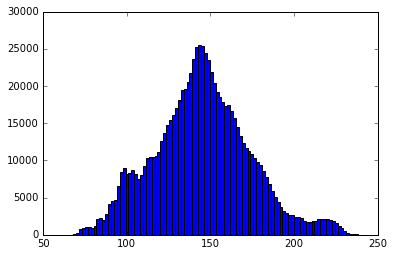

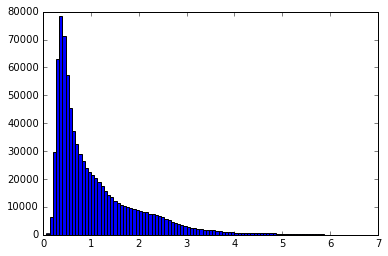

In [8]:
# 生inputのnormのhist
in_tens = make_hist(input) 

In [9]:
ms_out = sio.loadmat(proj_path+'data/blind/in4out4/output.mat')
out = ms_out['output']
out.shape

(15, 855000)

(1, 855000)
(5, 855000)
(9, 855000)


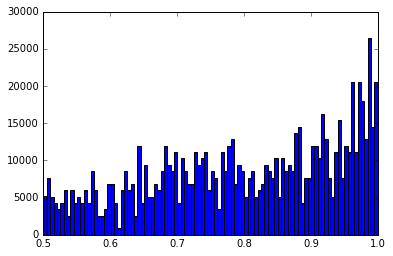

In [10]:
# outputのnomr のhist
# out0は予測する必要なし 全部1.0にしとけばいい
out_tens = make_hist(out) 

In [107]:
def c2v(tens_list):
    v_list = []
    for tens in tens_list:
        tmp = np.squeeze(TN_utils.comp2vec(tens.T[:, :, np.newaxis]))
        v_list.append(tmp)
        print tmp.shape
    return v_list

In [108]:
in_tensor_vec_list = c2v(in_tens)

(855000, 2)
(855000, 10)
(855000, 18)


In [134]:
def normalize(tens_list):
    normed_list = []
    coef_list = []
    for tens in tens_list:
        normed, coef = TN_utils.normalize_ex2_feature_vec(tens)
        plt.figure()
        plt.hist(np.linalg.norm(normed, axis=1))
        normed_list.append(normed)
        coef_list.append(coef)
        
    return normed_list, coef_list

In [135]:
# 正規化したinputのhist
normed_in, norm_coef = normalize(in_tensor_vec_list)

In [136]:
[a.shape for a in normed_in]

[(855000, 2), (855000, 10), (855000, 18)]

(855000, 2)
(855000, 10)
(855000, 18)


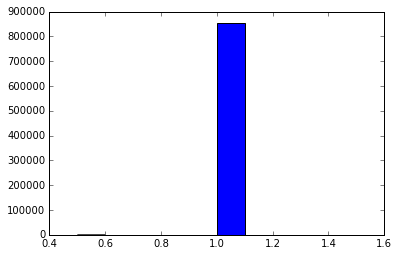

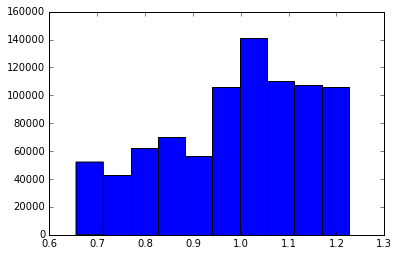

In [137]:
# 正規化したoutputのhist
normed_out, out_coef = normalize(c2v(out_tens))

In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [213]:
input_tensors, output_tensors = TN_utils.load_blind(input_L=4, output_L=4, folder_name='in4out4')

[(0, 1), (1, 6), (6, 15)] [(0, 1), (1, 6), (6, 15)]
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 2)
(855000, 10)
(855000, 18)


In [327]:
train_input, train_output, test_input, test_output, input_coef, output_coef = TN_utils.pre_blind(input_tensors, output_tensors, N=100000)

In [328]:
train_input[0].shape
test_input[0].shape

(19999, 2, 1)

In [329]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4], j_output=2, n_input_tensors_list=[1, 1, 1],
        n_hidden_tensors=100, func_key_list=['retanh', 'linear'])

In [ ]:
results = compling_multiorder.compile(
        train_input, train_output[1], test_input, test_output[1],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

[(0, 2), (2, 2), (2, 4), (4, 4)]
[(0, 2), (2, 2), (2, 4), (4, 4)]


In [ ]:
batch_size = 1000
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

In [ ]:
training_error_array

In [ ]:
pred_train2 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in in_tensor_vec_list],
                                            np.array(input_coef)[:, np.newaxis], 10)

In [ ]:
pred_train2.shape

In [344]:
# ちょっと違うな
plt.hist(np.linalg.norm(pred_train2, axis=1))

(array([   7312.,    7922.,    8213.,   14984.,   28501.,   42044.,
          78445.,  302618.,  349551.,   15410.]),
 array([  2.55106515e-05,   1.29760432e-01,   2.59495354e-01,
          3.89230275e-01,   5.18965197e-01,   6.48700118e-01,
          7.78435039e-01,   9.08169961e-01,   1.03790488e+00,
          1.16763980e+00,   1.29737473e+00]),
 <a list of 10 Patch objects>)

In [ ]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4], j_output=4, n_input_tensors_list=[1, 1, 1],
        n_hidden_tensors=100, func_key_list=['retanh', 'linear'])

In [ ]:
results = compling_multiorder.compile(
        train_input, train_output[2], test_input, test_output[2],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

In [ ]:
batch_size = 1000
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

(0, 0.02)

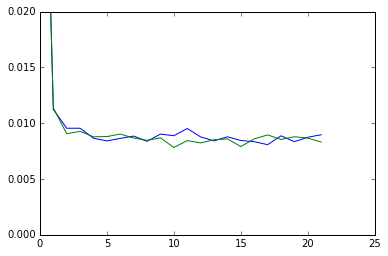

In [345]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.02)

In [ ]:
pred_train4 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in in_tensor_vec_list],
                                            np.array(input_coef)[:, np.newaxis], 18)

(array([   4346.,   14096.,  136285.,  141062.,   97666.,  130041.,
         204351.,  122055.,    4816.,     282.]),
 array([ 0.58487946,  0.65046296,  0.71604645,  0.78162995,  0.84721345,
         0.91279694,  0.97838044,  1.04396394,  1.10954744,  1.17513093,
         1.24071443]),
 <a list of 10 Patch objects>)

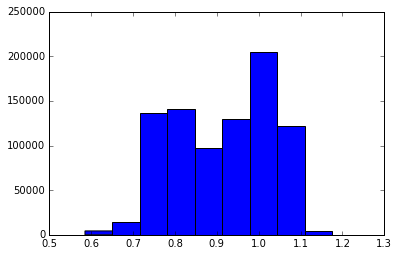

In [346]:
# かなりそれっぽい
plt.hist(np.linalg.norm(pred_train4, axis=1))

In [391]:
def post_process_blind(tens_list, output_coef):
    """
        tens_listのひとつ目の要素はL=2
        output_coefのひとつ目の要素はL=0
    """
    tens0 = np.concatenate([np.ones((tens_list[0].shape[0], 1)), np.zeros((tens_list[0].shape[0], 1))], axis=1)
    tens_list.insert(0, tens0)
    a = [TN_utils.vec2comp(tens) for tens in tens_list]
    return np.concatenate([tens * coef for tens, coef in zip(a, output_coef)], axis=1)

In [392]:
out = post_process([pred_train2, pred_train4], output_coef)

In [394]:
out.shape

(855000, 15)

In [403]:
sio.savemat(proj_path+'results/blind/Aug4/pred.mat', {'pred' : out}) 


In [400]:
pred_train2[0]*output_coef[1]

array([ -4.76330996e-01,   2.01750919e-01,   1.63189638e-02,
         9.51993242e-02,  -4.53426898e-01,   9.70970353e-12,
        -1.63189638e-02,   9.51993242e-02,  -4.76330996e-01,
        -2.01750919e-01], dtype=float32)

In [402]:
pred_train4[0]*output_coef[2]

array([  3.16255301e-01,  -2.38070205e-01,  -4.47670110e-02,
        -7.02758133e-02,   3.02613080e-01,  -6.62047714e-02,
        -3.12356837e-03,  -7.93400556e-02,   2.56312907e-01,
        -1.00344739e-10,   3.12356837e-03,  -7.93400556e-02,
         3.02613080e-01,   6.62047714e-02,   4.47670110e-02,
        -7.02758133e-02,   3.16255301e-01,   2.38070205e-01], dtype=float32)

In [ ]:
tensL0 = [np.concatenate([np.ones((1000, 1, 1)), np.zeros((1000, 1, 1))], axis=1)] # (N, 2, 1)